# 第4章: 形態素解析
夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．

In [5]:
import subprocess

def system(command, **options):
    proc = subprocess.Popen(command, shell=True,
                            stdout=subprocess.PIPE,
                            **options)
    return proc.communicate()[0].decode('utf-8')

def cat(filepath):
    return system(f'cat {filepath}')

In [6]:
system('''
mkdir -p data
cd data
if [ ! -f neko.txt ]
then curl -o neko.txt http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt
fi

if [ ! -x /usr/local/bin/mecab ]; then brew install mecab mecab-ipadic; fi

if [ ! -f neko.txt.mecab ]; then mecab neko.txt > neko.txt.mecab; fi
''')

''

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

---
## 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [36]:
import re
pattern = re.compile(r"(?P<surface>.+?)\t(?P<pos>[^,]+),(?P<pos1>[^,]+),([^,]*,){4}(?P<base>[^,]+).*")
def mcload(filename):
    sentence = []
    with open(filename, "r") as file:
        for word in file:
            words = pattern.match(word)
            if words:
                sentence.append({"surface":words.group("surface"), "base":words.group("base"), "pos":words.group("pos"), "pos1":words.group("pos1"), })
                if words.group("surface") == "。":
                    yield sentence
                    sentence = []

In [ ]:
for line in mcload("neko.txt.mecab"):
    print(line)

---
## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [ ]:
verb = []
for sentence in mcload("neko.txt.mecab"):
    for word in sentence:
        if word["pos"] == "動詞":
            verb.append(word["surface"])
print(set(verb))

---
## 32. 動詞の原形
動詞の原形をすべて抽出せよ．

In [ ]:
verb = []
for sentence in mcload("neko.txt.mecab"):
    for word in sentence:
        if word["pos"] == "動詞":
            verb.append(word["base"])
print(set(verb))

---
## 33. サ変名詞
サ変接続の名詞をすべて抽出せよ．

In [ ]:
norm = []
for sentence in mcload("neko.txt.mecab"):
    for word in sentence:
        if word["pos1"] == "サ変接続":
            norm.append(word["base"])
print(set(norm))

---
## 34. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [ ]:
setnorm = []
for sentence in mcload("neko.txt.mecab"):
    t1, t2, t3 = {}, {}, {}
    for word in sentence:
        if t1 == {}:
            t1, t2, t3 = word, word, word
        else:
            t1, t2, t3 = t2, t3, word
        if t2["surface"] == "の" and t1["pos"] == "名詞" and t3["pos"] == "名詞":
            #print(f"{t1['surface']}の{t3['surface']}")
            setnorm.append(f"{t1['surface']}の{t3['surface']}")
print(set(setnorm))

---
## 35. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [ ]:
setnorm2 = []
for sentence in mcload("neko.txt.mecab"):
    setnorm = []
    for word in sentence:
        if word["pos"] == "名詞":
            setnorm.append(word["surface"])
        else:
            if len(setnorm) > 1:
                setnorm2.append(("".join(setnorm)))
            setnorm = []
print(set(setnorm2))

---
## 36. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [ ]:
dic = {}
for sentence in mcload("neko.txt.mecab"):
    for word in sentence:
        if word["base"] in dic:
            dic[word["base"]] += 1
        else:
            dic[word["base"]] = 1
dic = sorted(dic.items(), key = lambda x:x[1], reverse = True)
print(dic)

#### 以下dicを用いる

---
## 37. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

<BarContainer object of 10 artists>

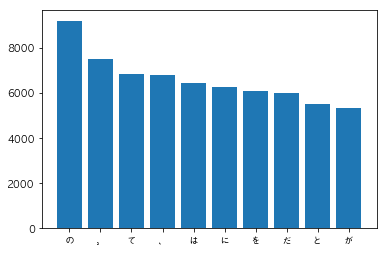

In [93]:
mpl.rcParams['font.family'] = 'AppleGothic'
plt.bar([i[0] for i in dic[:10]], [i[1] for i in dic[:10]])

---
## 38. ヒストグラム
単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

(array([1.1218e+04, 1.3000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 9.2030e+02, 1.8396e+03, 2.7589e+03, 3.6782e+03,
        4.5975e+03, 5.5168e+03, 6.4361e+03, 7.3554e+03, 8.2747e+03,
        9.1940e+03]),
 <a list of 10 Patch objects>)

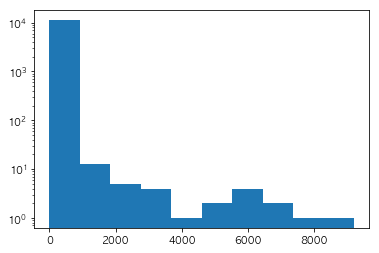

In [96]:
plt.hist([i[1] for i in dic], log = True)

---
## 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

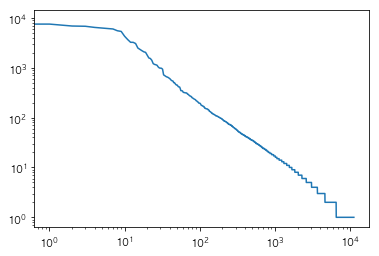

In [104]:
plt.plot(np.arange(len(dic)), [i[1] for i in dic])
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()